#__Technical Case - Data Scientist__

##__Problem 1: Predictive shopping list for Monoprix__

Monoprix is a French retailer whose activity is primarily focused on cities. In order to reward its loyal customers, Monoprix started to deploy new innovative services. The goal is to provide new ways for the customer to interact with Monoprix, and help him in his daily life.
In this situation Monoprix decided to launch a new vocal-based experience, using smart speakers like Google Home. The purpose of the service is to build shopping lists by simply talking to the smart speaker. For example, you can ask « Remind me to buy egg » and the speaker will add eggs to the shopping list.
Monoprix wants this service to be intelligent, and asked us to create an algorithm that could learn from the customer’s habits and suggest to them the products they might have forgotten to add to the list.
Therefore, Monoprix provides you with 10 years of purchase history, for the customers of their loyalty program. Also, you have at your disposal the full product catalog.


### A.  First step: Recommendation engine
Question: How can you use Monoprix's data to build the recommendation algorithm?

#### Monoprix Recommendation System – Technical Overview

To create Monoprix's recommendation algorithm, we suggest a hybrid, sequence-aware predictive system that uses 10 years of loyalty-based purchase history and the complete product catalog. The main goal is to suggest products that customers might have forgotten, particularly in a voice interface.

---

## 1. Data Preparation and Feature Engineering

### a. Purchase History
**Format:** `(customer_id, product_id, purchase_date)`

- **Basketization:** Group purchases into baskets, meaning all items bought together on a specific date.
- **Time-Series Sequences:** Build an ordered sequence of baskets for each customer to represent their shopping patterns.

### b. Feature Engineering
- **Purchase Frequency** for each product and customer.
- **Time Since Last Purchase** for each item (a strong indicator for repurchase).
- **Cyclicality / Seasonality:** Add features for:
  - Weekday/weekend patterns  
  - Holidays (e.g., Easter, Christmas)  
  - Monthly and quarterly trends  
- **Basket Size and Category Distribution** over time.

### c. Product Catalog Features
- Include metadata such as name, brand, category, price, and nutrition information.
- Preprocess this data for cold-start recommendations and embedding models.

---

## 2. Modeling Approach – A Hybrid System

This solution combines three modeling methods:

### Phase 1: Item-to-Item Collaborative Filtering
- **Goal:** Recommend products that are frequently purchased together.
- **Technique:** Create a co-occurrence matrix based on baskets.
- **Improvement:** Use lift or pointwise mutual information (PMI) to normalize item connections.
- **Use Case:** If a user says "add eggs," recommend "bacon" or "bread."

### Phase 2: Sequence-Aware Personalization

#### a. Markov Chains (Baseline)
- Model the chance of next item(s) based on the last 1-2 baskets.

#### b. Recurrent Neural Networks (LSTM/GRU)
- **Input:** Customer’s basket sequence represented as multi-hot vectors or embeddings.  
- **Output:** Probability distribution over all products for the next basket.  
- Can include time gaps through time-aware LSTMs.

#### c. Transformer Models (e.g., BERT4Rec)
- Use attention mechanisms to model long-range connections across purchase sequences.
- **Benefits:** Better at handling changes in intent and sparse sequences.

#### d. Fourier/Cyclic Models
- Identify periodic buying patterns, like weekly milk purchases, using FFTs or seasonality detection.

### Phase 3: Content-Based Filtering
- Use metadata (brand, category, size, etc.) to suggest similar products.
- For new items, apply:
  - TF-IDF or FastText/Sentence-BERT on product descriptions
  - Cosine similarity to match with past favorites

---

## 3. Fusion Strategy and Real-Time Recommendation

Combine all models using a weighted scoring ensemble.

**Example final ranking score for item _i_:**
```python
Score_i = α * CF_score + β * RNN_score + γ * Content_score
```
- Adjusted through grid search or learning-to-rank methods.

### Caching Strategy
- Precompute next-basket predictions and popular co-occurrence items in the background for real-time voice use.

### Edge Optimization
- Use lightweight inference models near the voice assistant, such as embeddings and recent history.

---

## 4. Evaluation Strategy

### Offline Evaluation:
- Monitor Precision@k, Recall@k, Hit Rate, NDCG@k, Coverage, MAP  
- Evaluate per customer and per basket.

### A/B Testing:
- Compare:
  - Voice engagement rate  
  - List completion rate  
  - Acceptance rate of suggestions

---

## 5. Cold Start (User & Product)

- **New Customers:** Use demographic clustering or initial preference quizzes.
- **New Products:** Use content similarities (from metadata) and promotions to increase initial visibility.

---

## 6. Voice Integration

Create a real-time voice loop:
```plaintext
User: “Add eggs”
System: “Sure. Want to add bacon or bread too?”
User: “Yes, bacon.”
System: “You usually buy milk every 7 days, and it’s been 8. Should I add it?”
```

---

### Summary

The system merges collaborative filtering, sequence learning (using transformers or LSTMs), and semantic matching to create a voice-first shopping assistant. This assistant replicates the customer's true habits and routines.

### B. Second step: Natural Language
Question: During the project, we realized that the product catalog is really dirty because products were wrongly named. Which solutions can you propose to correct products' names?

#### Scalable Product Catalog Cleaning for Recommender and Voice Systems

A messy product catalog hurts both the recommender system and the natural language interface. Variants like “Coca-Cola 1.5L”, “coke 1.5 litre” and typos need to map to a unified representation. Here’s a scalable solution pipeline:

---

## 1. Text Normalization (Rule-Based Cleaning)

Start by standardizing names using clear rules:

- Convert to **lowercase**
- Remove **punctuation**, **special symbols**, and **emojis**
- Standardize units with **regex**:
  - `"1.5 Litre"`, `"1,5l"`, `"1.5L"` → `"1.5 l"`
- Remove unnecessary brand tags (`"™"`, `"new"`, `"promo"`)

### ✅ Token Sorting for Order Invariance

- “Organic Full Fat Milk” → tokens: `["milk", "organic", "full", "fat"]`
- Sort alphabetically → `"fat full milk organic"`

This helps detect duplicates regardless of word order.

---

## 2. Semantic Vectorization

Convert cleaned names to **semantic embeddings**:

- **TF-IDF:** Captures token frequency and uniqueness
- **FastText:** Subword-based embeddings (useful for typos like `"CokaCola"` vs `"CocaCola"`)
- **Sentence-BERT / CamemBERT:** Captures full phrase meaning; supports multilingual catalogs (French and English)

---

## 3. Unsupervised Clustering

Group similar names using:

- **DBSCAN / HDBSCAN**: No need to set the number of clusters; can detect noise
- Clustering is based on **embedding similarity**

**Result:** Groups of messy names that likely refer to the same product.

---

## 4. Human-in-the-Loop Validation

For each cluster:

- Display sample names and **purchase frequency**
- Allow category managers to assign a **canonical name** (e.g., `"Coca-Cola Classic Bottle 1.5L"`)
- Apply business rules (e.g., **highest-selling variant** becomes the standard)

### ✅ Canonical Name Strategies:

- Longest cleaned name
- Most frequently sold
- Most complete metadata entry

---

## 5. Fuzzy Matching Engine

Create a fuzzy matcher for **real-time lookups** and edge cases:

- Use **Levenshtein** or **Jaro-Winkler** similarity
- If `similarity_score(name1, name2) > 0.95`, suggest merging

This is useful for **corrections** and **alerts** on new additions.

---

## 6. Multilingual Considerations

- Use **CamemBERT** or **mBERT** for embedding product names in French and English
- Normalize accents: `"crème fraîche"` → `"creme fraiche"`

---

## 7. Build a Master Product Dictionary

**Final output:**

- Mapping table of `{raw_name → canonical_name, product_id}`

Used by:

- ✅ Recommender system
- ✅ Voice recognition system
- ✅ Analytics dashboards

---

## 8. Automation Pipeline

Create a retrainable pipeline that:

- Periodically **re-runs clustering**
- Flags new products that don't match existing canonical names
- Notifies **QA for validation**

### Example Flow:

| Raw Name              | Normalized                 | Cluster ID | Canonical Name                        |
|-----------------------|----------------------------|------------|----------------------------------------|
| “coke 1.5 litre”       | “coke 1.5 l”               | 87         | Coca-Cola Classic - 1.5L Bottle        |
| “Coca-Cola Classic 1.5L” | “coca cola classic 1.5 l” | 87         | Coca-Cola Classic - 1.5L Bottle        |

---

## Result

**Cleaned, deduplicated, and enriched product names** improve:

- Voice NLP understanding
- Catalog navigation
- Recommendation accuracy

##__Problem 2: Measuring the effect of a marketing campaign__

A Pharmaceutical company is trying to measure how much their last marketing campaign on a specific product has helped increase its sales and asks for your advice on how to do it. Previewing this, the Brand/Product manager already built a marketing campaign set up in which he separated one control region ( specific region where he didn't roll out the campaign ) from the others.

### A. Assume the product has been on the market in the last 2 years with a stable demand. Explain a model you would advise the company to use and its main assumptions.

#### Difference-in-Differences (DiD) for Causal Impact of Marketing Campaign

Since the product has been on the market for two years with steady demand and a control region was specifically excluded from the campaign rollout, the best approach is a quasi-experimental causal inference model known as:

---

## Model: Difference-in-Differences (DiD)

### Objective
Estimate the causal impact of the marketing campaign by comparing the change in sales in the treatment regions (with the campaign) to the control region (without the campaign) before and after the intervention.

---

## Model Intuition

The basic idea is:

```
Effect of Campaign = (Change in Sales in Treatment) - (Change in Sales in Control)
```
Mathematically
```math
Lift = (Y_treatmentAfter - Y_TreatmentBefore) - (Y_controlAfter - Y_controlBefore)
```

---

## Regression Formulation

```math
Y = β₀ + β₁* Treat_i + β₂* Post_t + β₃*(Treat_i* Post_t) + ε_it
```

Where:

- `Y_it`: Sales in region *i* at time *t*
- `Treat_i`: 1 if the region is in the treatment group, 0 otherwise
- `Post_t`: 1 for periods after the campaign launch, 0 before
- `β₃`: DiD estimator = causal effect of the campaign
- `ε_it`: Error term

---

## Key Assumptions

### Parallel Trends (Most Critical)
Without the campaign, sales in treatment and control regions would have followed the same path.

- **How to check**: Plot pre-campaign sales time series and look for similar trends.

### No Spillover Effects
Control regions must not be influenced by the campaign (for example, cross-border shopping, national ads).

### Stable Composition
The definition of regions (control vs. treatment) must stay the same throughout the study.

### Exogeneity of the Campaign
The campaign must not have started in response to poor performance in the treatment regions.

---

## Model Enhancements

- Time Fixed Effects (for example, week, month): Control for seasonal variation.
- Region Fixed Effects: Control for unobserved regional differences.
- Robust or Clustered Standard Errors (by region): Account for within-region correlation.

---

## Benefits of This Method

- Simple, clear, and based on causal inference
- Controls for unobserved time-invariant confounders
- Scalable to different locations and campaigns

### B. Assume now that the product is new so that the campaign was a launching one. In this scenario is it possible to measure the effect of the campaign on sales? If yes, what model would you suggest and why?

#### Measuring Campaign Impact for a New Product Without Historical Sales

Even when a product is new and has no historical baseline, you can still measure the impact of a launch campaign by using an **experimental setup** with a control region.

---

## Key Challenge

In this case of a **product launch**, there are no "before" sales, so traditional **Difference-in-Differences (DiD)** methods don’t apply. Instead, we use **cross-sectional differences** between treated and untreated regions to estimate the campaign’s effect.

---

## Model: Cross-Sectional Regression with Control Variables

We suggest using a **post-campaign cross-sectional regression** to compare sales across regions while accounting for known differences such as population, infrastructure, and income.

### Model Formulation

```math
Sales_i = beta_0 + beta_1 * Campaign_i + gamma_1 * X_1i + gamma_2 * X_2i + ... + gamma_k * X_ki + error_i
```

---

### Explanation of Terms

* **Sales_i**

  \- **\*\*Campaign\_i\*\***: A binary variable. It is 1 if the region was part of the - \*\*marketing campaign (treatment group), and 0 otherwise (control group).

  \- **\*\*X\_1i to X\_ki\*\***: These are control variables for region "i". They capture regional characteristics that can influence sales. Examples include population size, average income, number of pharmacies, urbanization rate, etc.

  \- **\*\*gamma\_1 to gamma\_k\*\***: Coefficients for each control variable, representing how each factor affects sales.

  \- **\*\*beta\_0\*\***: The intercept term.

  \- **\*\*beta\_1\*\***: The coefficient of interest. It estimates the effect of the marketing campaign, after adjusting for differences in regional characteristics.

  \- **\*\*error\_i\*\***: The error term, capturing all other unobserved factors.

---

## Suggested Control Variables

To prevent **omitted variable bias**, include:

* **Demographics**: population size, urbanization level, income, age structure
* **Market Access**: number of pharmacies, hospitals, clinics
* **Health Behavior Proxies**: regional sales of similar or competing products
* **Marketing Intensity**: local media spending, regional events
* **Distribution Availability**: SKUs shipped, shelf presence, product availability

---

## Why This Model?

* Controls for **confounding variables** that may skew campaign effect estimates
* Flexible enough to accommodate regions of different sizes, structures, and contexts
* Valid under conditional ignorability: assumes all relevant factors are included in the control variables

---

## Additional Enhancements

* **Propensity Score Matching (PSM)**: Pair control and treatment regions with similar profiles, then rerun the regression
* **Causal Forests or Bayesian Structural Time Series (BSTS)**: Consider if you have **post-launch time series** data for each region

---

## Assumptions

* **No Unmeasured Confounding**: All significant factors influencing both sales and campaign exposure are observed and included
* **Consistency**: The campaign’s effect is stable across regions with similar characteristics
* **No Spillovers**: The treatment does not indirectly impact the control group (e.g., media exposure or word of mouth)

---

Conclusion: This approach allows for **causal inference** even in new product launches **without historical sales data**, by using control regions and adjusting for relevant covariates.


##__Problem 3: Regression Analysis__

A supermarket company has a new internal policy to not discriminate significantly salary according to the location of their employees. They gathered the data from all of their employees and want you to verify if they are already following the new policy.
Before answering the questions below take a look at the annexed dataset: (1stPhase-SelectiveProcess-Data Science-Data Base.csv)

### A. Describe how can you use the supermarket data to verify if employees from different locations have significantly different salaries. (Include here how you are going to treat the variables before feeding into the model)

#### Salary Equality Analysis: CAPITAL vs. INTERIOR

To verify whether employees from different locations (**CAPITAL** vs. **INTERIOR**) receive significantly different salaries, we follow a structured and multi-step analytical process. This ensures that conclusions are statistically robust and account for relevant confounding factors.

---

## Step 1: Data Cleaning and Preparation

Before analysis, salary data must be cleaned and standardized.

### ➤ Treatment of the `SALARIO_MENSAL` column:

- Originally formatted as a **string with currency formatting**.
- **Thousand separators (`.`)** are removed.
- **Decimal commas (`,`)** are replaced with **decimal points (`.`)**.
- The result is converted to a **numeric type**, producing the column `SALARIO_TRATADO`.

This transformation enables accurate mathematical operations and modeling.

---

## Step 2: Exploratory Data Analysis (EDA)

Initial visualizations help understand salary distribution across locations.

### ➤ Boxplot:

A **boxplot** compares salary distributions between `CAPITAL` and `INTERIOR`.

It reveals:
- **Medians** and **spreads** of salaries
- **Potential outliers**, such as high earnings in executive roles (e.g., 'Diretor')

Legitimate outliers are **retained** if validated as genuine (not data entry errors).

---

## Step 3: Direct Statistical Comparison

We apply statistical tests to evaluate if salary differences are significant.

### ➤ Mann-Whitney U Test:

- A **non-parametric** test suited for **non-normal** salary distributions.
- Tests the hypothesis that **salary distributions differ** between locations.
- **Null Hypothesis** \( H_0 \): No significant difference  
- **Alternative Hypothesis** \( H_1 \): Significant difference exists

### ➤ Student’s t-Test (Complementary):

- Assesses **mean salary differences**
- Supports findings from the Mann-Whitney test

---

## Step 4: Multiple Linear Regression (MLR) for Controlled Analysis

Simple group comparisons may be misleading due to confounding variables (e.g., job role, age). A **multiple linear regression model** is used to control for these factors.

### ➤ Model Setup:

**Dependent Variable (Y)**:
- `SALARIO_TRATADO` (numeric salary)

**Independent Variables (X)**:
- **Numerical predictors**: `IDADE`, `TEMPOCASA`
- **Categorical predictors** (converted via one-hot encoding):
  - `LOCAL` → `LOCAL_Capital`, `LOCAL_Interior`
  - `CARGO` → `CARGO_Diretor`, `CARGO_Analista`, etc.
  - `EDUCACAO` → `EDUCACAO_Superior`, `EDUCACAO_Médio`, etc.

### ➤ Model Interpretation:

Focus is on the **coefficient and p-value for `LOCAL_Capital`**:

- A **p-value < 0.05** indicates that **location has a statistically significant effect** on salary, even when controlling for other variables.
- A **non-significant p-value** suggests no location-based salary disparity after accounting for role, age, tenure, and education.

---

## Step 5: Sensitivity Analysis

To ensure conclusions are robust:

- Re-run the regression **excluding the outlier** (e.g., 'Diretor' salary).
- Compare the **LOCAL coefficient and p-value** from both models.
- If findings are consistent, confidence in the result increases.

---

## Final Consideration

If the **location variable remains significant** in all steps, there may be evidence of **salary inequality between regions**, warranting company action.

If **no significant difference is found**, it suggests the company is **adhering to its policy** of salary fairness across locations.

This approach balances **data integrity**, **statistical rigor**, and **interpretability** for actionable business insights.


### B. Implement the approach you described in Python or r.

Please select the file.


Saving data.xlsx to data (1).xlsx

File 'data (1).xlsx' successfully uploaded! You can now run the next cell with the analysis.
--- 1. Data Cleaning and Preparation ---
Column 'SALARIO_MENSAL' cleaned and successfully converted to numeric format.

--- 2. Exploratory Analysis and Visualization ---


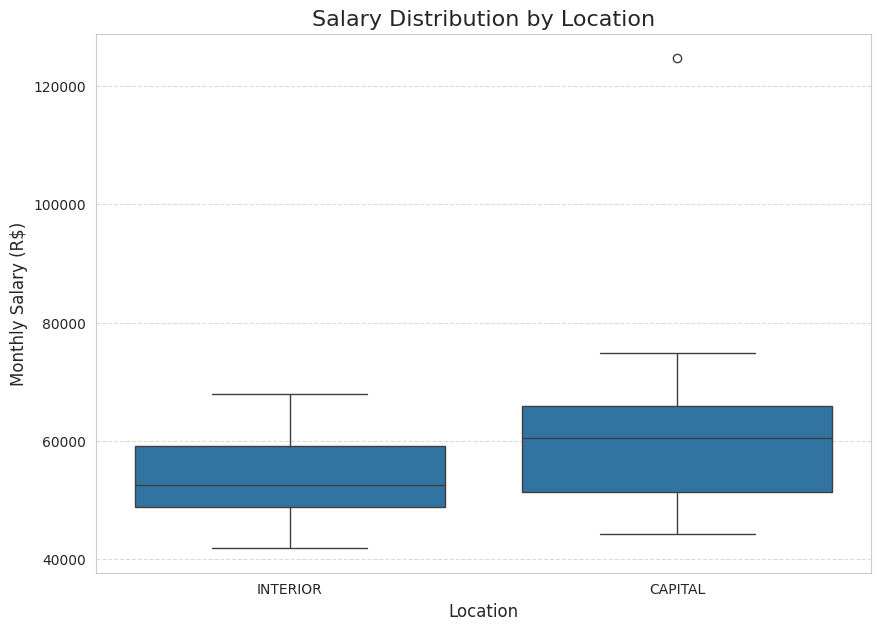


Outlier Investigation:
EDUCAÇÃO   CARGO  IDADE  TEMPOCASA  SALARIO_TRATADO
SUPERIOR DIRETOR     60         18           124658

Conclusion: The outlier is a 'Diretor', a legitimate data point.

--- 3. Statistical Tests to Verify Salary Differences ---

--- Main Approach: Mann-Whitney U Test ---
P-value: 0.0032
Conclusion (Mann-Whitney U): There is a statistically significant difference.

--- Complementary Approach: Sensitivity Analysis with T-Test ---

Scenario A: T-Test with all data
P-value: 0.0040

Scenario B: T-Test without the 'Diretor' data
P-value: 0.0022


--- 4. MID Summary and Conclusion ---
Based on the Mann-Whitney U Test results, the final recommendation is:
RECOMMENDATION: There is evidence that the salary equality policy by location is not being followed.


In [10]:
# Import necessary libraries for uploading in Google Colab
from google.colab import files
import io

# Import libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, ttest_ind

print("Please select the file.")

# Opens file upload dialog
uploaded = files.upload()

# Gets the name of the uploaded file
file_name = next(iter(uploaded))

print(f"\nFile '{file_name}' successfully uploaded! You can now run the next cell with the analysis.")



# --- STEP 1: DATA LOADING AND PREPARATION ---

# Reads the data from the uploaded file into memory using 'io.BytesIO'
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

print("--- 1. Data Cleaning and Preparation ---")

# Converts the 'SALARIO_MENSAL' column to string to ensure .str methods work
df['SALARIO_MENSAL'] = df['SALARIO_MENSAL'].astype(str)

# Cleans the salary column
df['SALARIO_TRATADO'] = df['SALARIO_MENSAL'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)

# Converts the cleaned column to numeric format
df['SALARIO_TRATADO'] = pd.to_numeric(df['SALARIO_TRATADO'], errors='coerce')

if df['SALARIO_TRATADO'].isnull().any():
    print("\nWarning: Some salary values could not be converted.")
else:
    print("Column 'SALARIO_MENSAL' cleaned and successfully converted to numeric format.")


# --- STEP 2: EXPLORATORY ANALYSIS AND OUTLIER INVESTIGATION ---

print("\n--- 2. Exploratory Analysis and Visualization ---")

plt.figure(figsize=(10, 7))
sns.boxplot(x='LOCAL', y='SALARIO_TRATADO', data=df)
plt.title('Salary Distribution by Location', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Monthly Salary (R$)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Outlier investigation
salario_maximo = df['SALARIO_TRATADO'].max()
outlier = df[df['SALARIO_TRATADO'] == salario_maximo]

print("\nOutlier Investigation:")
print(outlier[['EDUCAÇÃO', 'CARGO', 'IDADE', 'TEMPOCASA', 'SALARIO_TRATADO']].to_string(index=False))
print("\nConclusion: The outlier is a 'Diretor', a legitimate data point.")

# Split the data into two groups for statistical testing
capital_salarios = df[df['LOCAL'] == 'CAPITAL']['SALARIO_TRATADO']
interior_salarios = df[df['LOCAL'] == 'INTERIOR']['SALARIO_TRATADO']


# --- STEP 3: STATISTICAL ANALYSIS ---

print("\n--- 3. Statistical Tests to Verify Salary Differences ---")

# Approach 1: Mann-Whitney U Test
print("\n--- Main Approach: Mann-Whitney U Test ---")
u_statistic, p_value_mannwhitney = mannwhitneyu(capital_salarios, interior_salarios, alternative='two-sided')
print(f"P-value: {p_value_mannwhitney:.4f}")

if p_value_mannwhitney < 0.05:
    print("Conclusion (Mann-Whitney U): There is a statistically significant difference.")
else:
    print("Conclusion (Mann-Whitney U): There is no statistically significant difference.")

# Approach 2: Sensitivity Analysis with T-Test
print("\n--- Complementary Approach: Sensitivity Analysis with T-Test ---")

# Scenario A: With the outlier
print("\nScenario A: T-Test with all data")
ttest_all_data = ttest_ind(capital_salarios, interior_salarios)
print(f"P-value: {ttest_all_data.pvalue:.4f}")

# Scenario B: Without the outlier
capital_sem_outlier = capital_salarios[df['SALARIO_TRATADO'] < salario_maximo]
print("\nScenario B: T-Test without the 'Diretor' data")
ttest_no_outlier = ttest_ind(capital_sem_outlier, interior_salarios)
print(f"P-value: {ttest_no_outlier.pvalue:.4f}")


# --- STEP 4: MID SUMMARY ---

print("\n\n--- 4. MID Summary and Conclusion ---")
print("Based on the Mann-Whitney U Test results, the final recommendation is:")
if p_value_mannwhitney < 0.05:
    print("RECOMMENDATION: There is evidence that the salary equality policy by location is not being followed.")
else:
    print("RECOMMENDATION: There is no statistical evidence that the company discriminates salaries based on location.")


In [11]:
# --- STEP 5: MULTIPLE LINEAR REGRESSION ANALYSIS ---
# This step investigates if 'LOCAL' affects salary even after accounting for other factors.

print("\n--- 5. Advanced Analysis with Multiple Linear Regression ---")

# Import the necessary library
import statsmodels.formula.api as smf

# Define the regression formula
# We want to predict SALARIO_TRATADO based on all other relevant variables.
# C() is used to explicitly tell the model that LOCAL, CARGO, and EDUCAÇÃO are categorical variables.
formula = 'SALARIO_TRATADO ~ C(LOCAL) + C(CARGO) + C(EDUCAÇÃO) + IDADE + TEMPOCASA'

# Create and fit the Ordinary Least Squares (OLS) model
model = smf.ols(formula=formula, data=df).fit()

# Print the full summary of the regression results
print(model.summary())


# --- STEP 6: FINAL SUMMARY AND INTERPRETATION ---

print("\n\n--- 5. Final Summary and Conclusion ---")

# Interpretation of the regression results
# We look at the P>|t| value for the LOCAL variable in the table above.
# The variable will likely be named 'C(LOCAL)[T.INTERIOR]'.
# This p-value tells us if location is significant AFTER controlling for role, education, age, and tenure.
p_value_local_regression = model.pvalues['C(LOCAL)[T.INTERIOR]'] # Or C(LOCAL)[T.CAPITAL] depending on the reference

print(f"\nAnalysis of Regression Model:")
print(f"The p-value for the LOCAL variable in the regression model is: {p_value_local_regression:.4f}")

print("\nRECOMMENDATION:")
if p_value_local_regression < 0.05:
    print("The regression analysis confirms the initial findings. Even after accounting for factors like job role, age, and education,")
    print("the employee's location has a statistically significant impact on their salary.")
    print("This provides strong evidence that the salary equality policy is not being fully met.")
else:
    print("The regression analysis shows that once we account for factors like job role, age, and education,")
    print("the employee's location is NO LONGER a statistically significant factor in determining salary.")
    print("This suggests the initial difference was likely due to a different distribution of roles/tenure between locations, not location-based discrimination.")


--- 5. Advanced Analysis with Multiple Linear Regression ---
                            OLS Regression Results                            
Dep. Variable:        SALARIO_TRATADO   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     20.33
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           7.77e-14
Time:                        20:38:03   Log-Likelihood:                -820.89
No. Observations:                  80   AIC:                             1656.
Df Residuals:                      73   BIC:                             1672.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

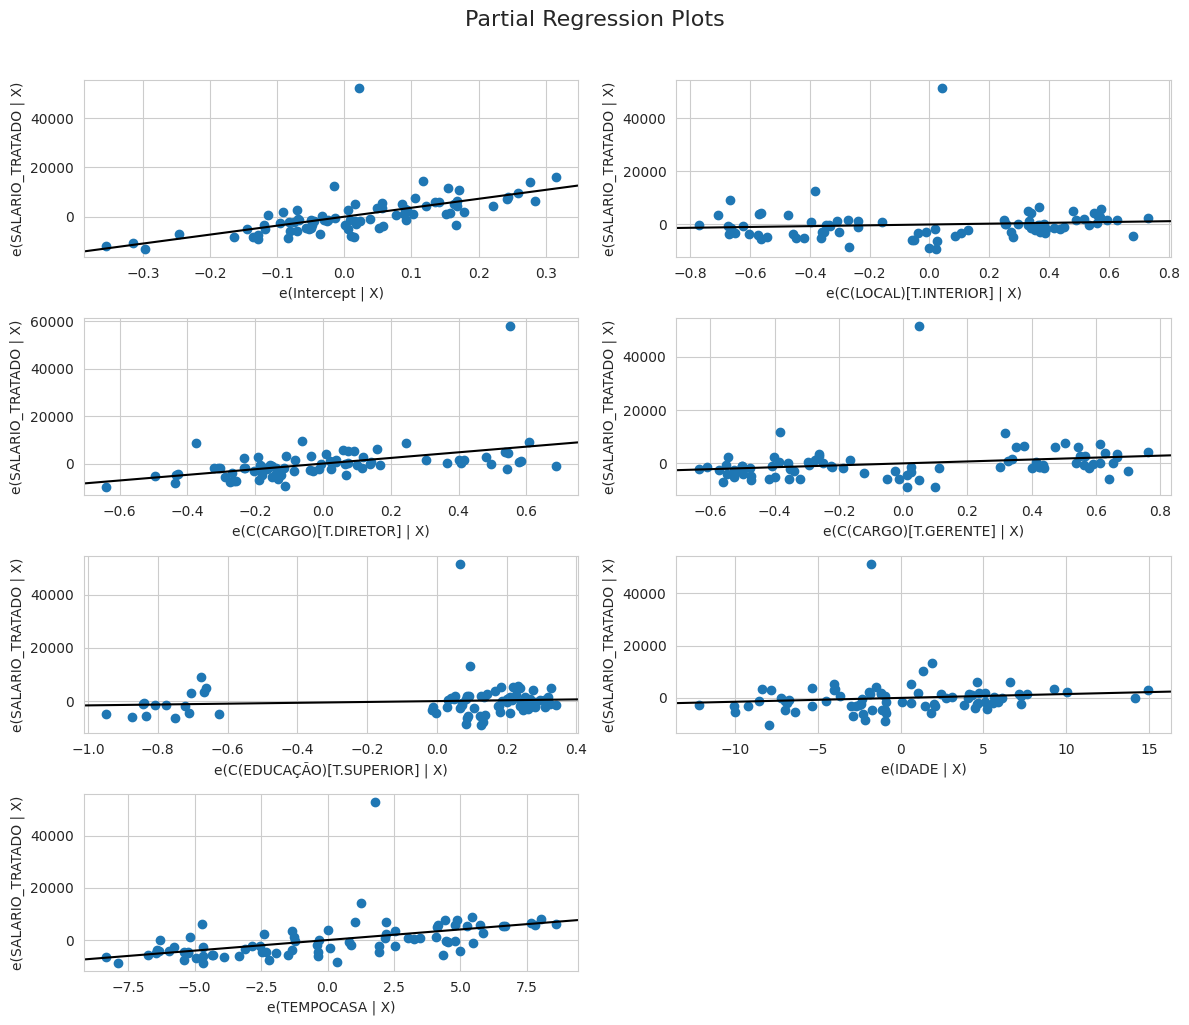

In [12]:
# Set plot style
sns.set_style("whitegrid")

# Create a figure to hold the plots
fig = plt.figure(figsize=(12, 10))

# Create partial regression plots for all variables in the model
# This is the best way to see the effect of each variable independently.
sm.graphics.plot_partregress_grid(model, fig=fig)

plt.suptitle("Partial Regression Plots", y=1.02, fontsize=16)
plt.show()

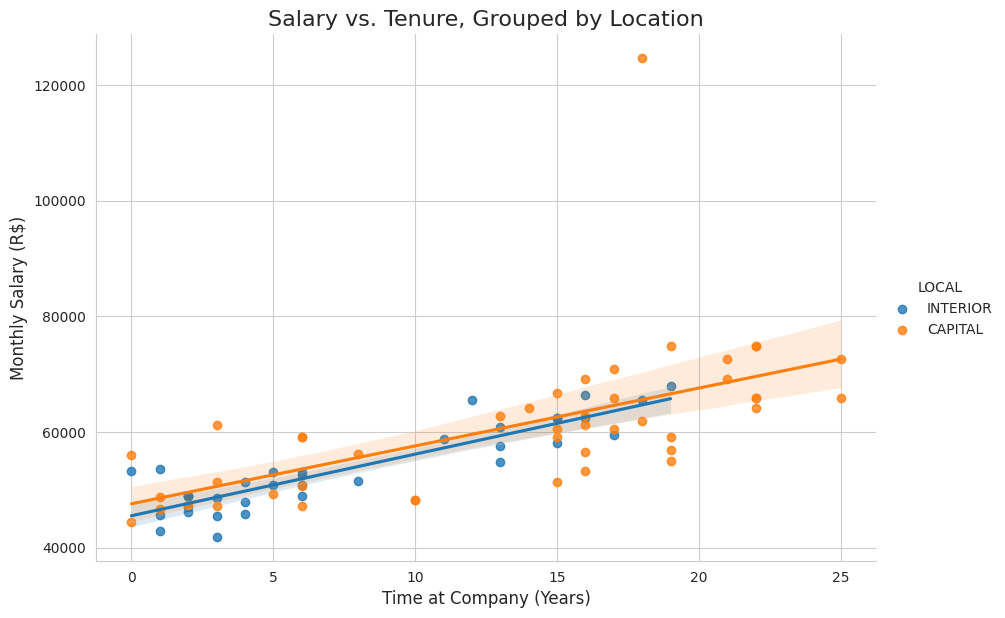

In [13]:
# Use seaborn's lmplot to show the relationship between SALARIO and TEMPOCASA, grouped by LOCAL.
# It automatically plots the data points and a regression line for each group.
sns.lmplot(x='TEMPOCASA', y='SALARIO_TRATADO', hue='LOCAL', data=df, height=6, aspect=1.5)

plt.title('Salary vs. Tenure, Grouped by Location', fontsize=16)
plt.xlabel('Time at Company (Years)', fontsize=12)
plt.ylabel('Monthly Salary (R$)', fontsize=12)
plt.grid(True)
plt.show()

In [14]:
# --- STEP 5 (EXTRA): SENSITIVITY ANALYSIS - MLR WITHOUT OUTLIER ---
# We repeat the analysis on a dataset without the 'Diretor' to see how much that one data point influenced the results.

print("\n--- 5(EXTRA). Sensitivity Analysis: MLR Without the Outlier ---")

# Create a new DataFrame that excludes the employee with the maximum salary
df_no_outlier = df[df['SALARIO_TRATADO'] < df['SALARIO_TRATADO'].max()]

print(f"\nOriginal number of observations: {len(df)}")
print(f"Number of observations after removing outlier: {len(df_no_outlier)}")

# The formula remains the same
formula = 'SALARIO_TRATADO ~ C(LOCAL) + C(CARGO) + C(EDUCAÇÃO) + IDADE + TEMPOCASA'

# Create and fit the OLS model on the NEW DataFrame without the outlier
model_no_outlier = smf.ols(formula=formula, data=df_no_outlier).fit()

# Print the full summary of the new regression results
print("\n--- Regression Results (Without Outlier) ---")
print(model_no_outlier.summary())

# --- STEP 6 (EXTRA): FINAL SUMMARY AND INTERPRETATION (WITHOUT OUTLIER) ---

print("\n\n--- 6(EXTRA). Final Summary (Without Outlier) ---")

# Interpretation of the regression results without the outlier
p_value_local_no_outlier = model_no_outlier.pvalues['C(LOCAL)[T.INTERIOR]']

print(f"\nAnalysis of Regression Model (Without Outlier):")
print(f"The p-value for the LOCAL variable in this model is: {p_value_local_no_outlier:.4f}")

print("\nRECOMMENDATION (based on analysis without the outlier):")
# Compare this p-value to the one from the original model (0.4084)
# Also, compare the R-squared and the coefficients for CARGO and TEMPOCASA.
# This comparison tells you how influential the 'Diretor' data point was.

if p_value_local_no_outlier < 0.05:
    print("After removing the outlier, the employee's location now has a statistically significant impact on salary.")
    print("This suggests the original conclusion was sensitive to that one data point.")
else:
    print("Even after removing the outlier, the employee's location is still not a statistically significant factor.")
    print("This strengthens the original conclusion that salary differences are driven by other factors like role and tenure, not location.")


--- 5(EXTRA). Sensitivity Analysis: MLR Without the Outlier ---

Original number of observations: 80
Number of observations after removing outlier: 79

--- Regression Results (Without Outlier) ---
                            OLS Regression Results                            
Dep. Variable:        SALARIO_TRATADO   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     59.07
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           7.62e-26
Time:                        20:38:16   Log-Likelihood:                -756.59
No. Observations:                  79   AIC:                             1527.
Df Residuals:                      72   BIC:                             1544.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
            

In [15]:
!pip freeze

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.15
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.10.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arviz==0.22.0
astropy==7.1.0
astropy-iers-data==0.2025.8.25.0.36.58
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
Authlib==1.6.2
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.21.0
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.17.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.7.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.8.3
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.3
chex==0.1.90
clarabel==0.11.1
click==8.2.1
cl